In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


YF.download() has changed argument auto_adjust default to True
Downloaded 5202 days of data


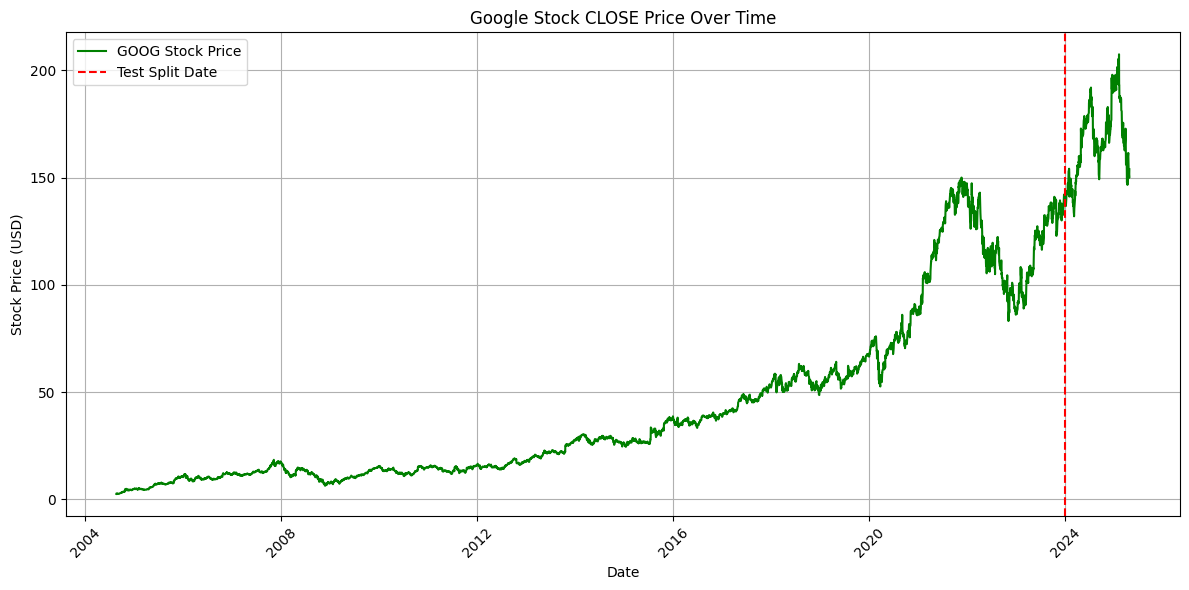

In [2]:
# Download stock data using Yahoo Finance (using a date we know has data)
# Changed end date to April 23, 2025 (assuming this is 3 days before current date)
stock_data = yf.download('GOOG', start='2004-08-19', end='2025-04-23', interval='1d', progress=False) #08/19/2004 is the date Google went public

# Check if data was downloaded successfully
if stock_data.empty:
    print("No data was downloaded. Check your internet connection or date range.")
    exit()
    
print(f"Downloaded {len(stock_data)} days of data")

# Extract the 'Close' prices and dates
stock_close = stock_data['Close'].copy()

# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(stock_close, label='GOOG Stock Price', color='green')
plt.title('Google Stock CLOSE Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
#Add vertical line for test split date
plt.axvline(x=pd.Timestamp('2024-01-01'), color='red', linestyle='--', label='Test Split Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
stock_data

Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2004-08-19,2.487352,2.579567,2.378775,2.478922,897427216
2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2004-08-23,2.711942,2.813082,2.703266,2.745408,366857939
2004-08-24,2.599647,2.766478,2.567420,2.757554,306396159
2004-08-25,2.627658,2.677238,2.575105,2.601877,184645512
...,...,...,...,...,...
2025-04-15,158.679993,162.050003,157.645004,161.570007,15690800
2025-04-16,155.500000,158.179993,153.910004,155.470001,16921500


In [4]:
stock_close

Ticker,GOOG
Date,
2004-08-19,2.487352
2004-08-20,2.684922
2004-08-23,2.711942
2004-08-24,2.599647
2004-08-25,2.627658
...,...
2025-04-15,158.679993
2025-04-16,155.500000
2025-04-17,153.360001


In [5]:
# Check stationarity with ADF Test
def check_stationarity(timeseries):
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adf_test[0:4], index=['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used'])
    for key, value in adf_test[4].items():
        adf_output[f'Critical Value ({key})'] = value
    print(adf_output)
    
    if adf_test[1] <= 0.05:
        print("Data is stationary (Reject H0)")
    else:
        print("Data is not stationary (Fail to reject H0)")
    
    return adf_test[1] <= 0.05  # Returns True if stationary

print("\nChecking stationarity of original data:")
is_stationary = check_stationarity(stock_close)


Checking stationarity of original data:
Results of Augmented Dickey-Fuller Test:
ADF Statistic              0.153299
p-value                    0.969517
# Lags Used               33.000000
# Observations Used     5168.000000
Critical Value (1%)       -3.431616
Critical Value (5%)       -2.862099
Critical Value (10%)      -2.567068
dtype: float64
Data is not stationary (Fail to reject H0)



Checking stationarity after 1 differencing:
Results of Augmented Dickey-Fuller Test:
ADF Statistic          -1.172160e+01
p-value                 1.409102e-21
# Lags Used             3.200000e+01
# Observations Used     5.168000e+03
Critical Value (1%)    -3.431616e+00
Critical Value (5%)    -2.862099e+00
Critical Value (10%)   -2.567068e+00
dtype: float64
Data is stationary (Reject H0)


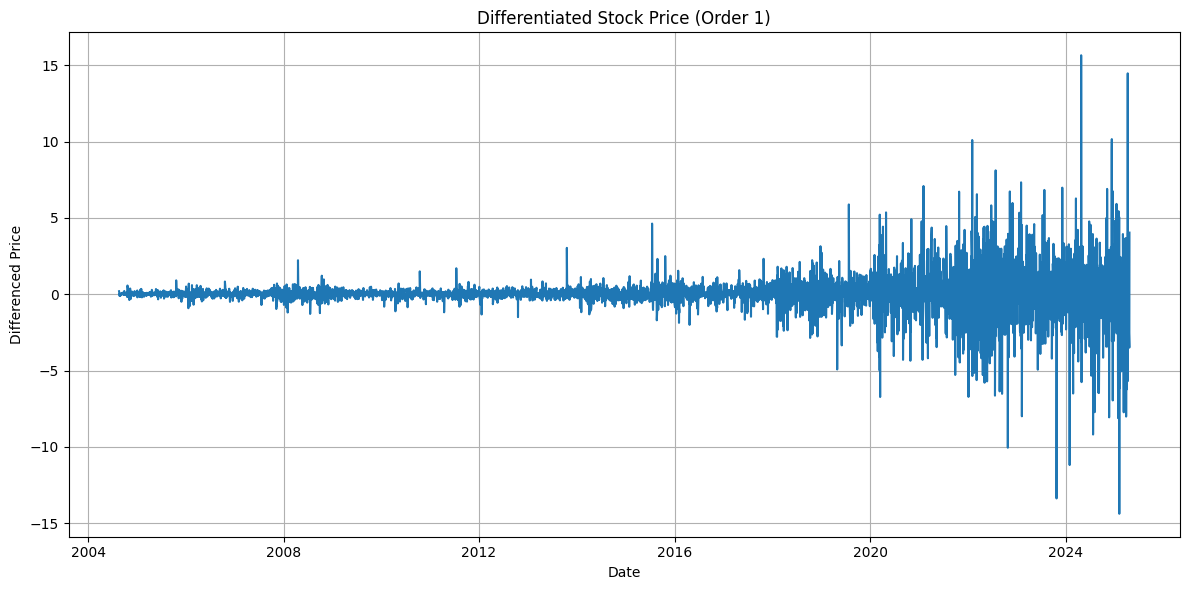

In [6]:
# Differentiate if not stationary
diff_order = 0
diff_data = stock_close.copy()

while not is_stationary and diff_order < 3:  # Limit to 3 differencing operations
    diff_order += 1
    diff_data = diff_data.diff().dropna()
    
    print(f"\nChecking stationarity after {diff_order} differencing:")
    is_stationary = check_stationarity(diff_data)
    
    plt.figure(figsize=(12, 6))
    plt.plot(diff_data)
    plt.title(f'Differentiated Stock Price (Order {diff_order})')
    plt.xlabel('Date')
    plt.ylabel('Differenced Price')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

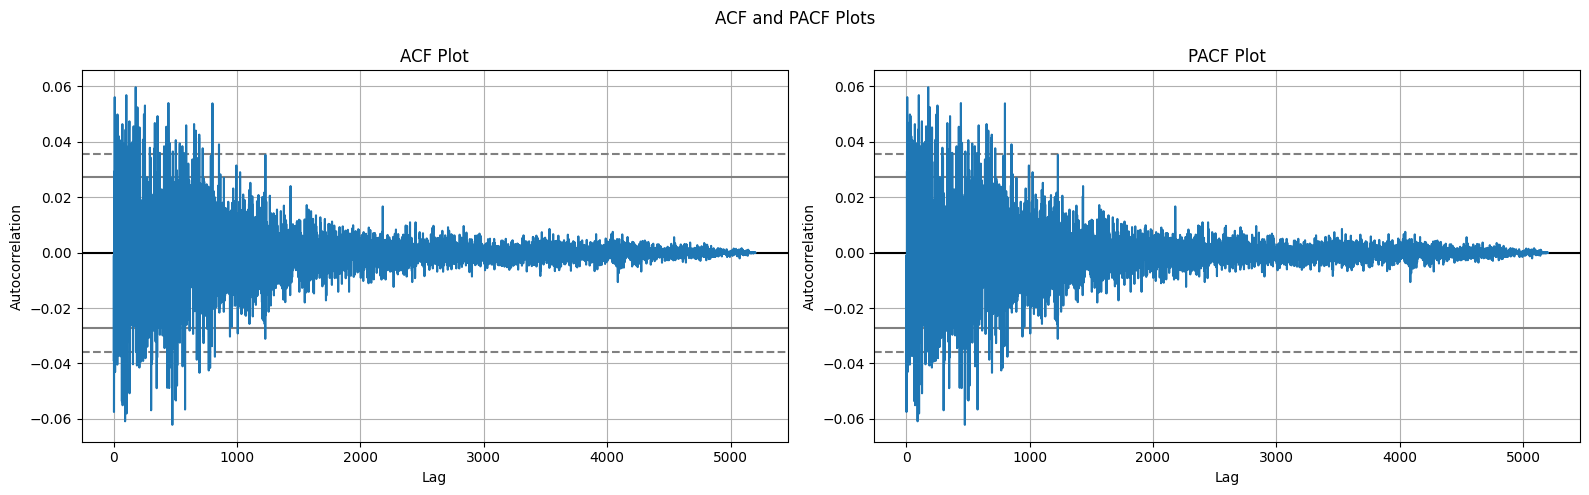


Order of differencing (d): 1


In [7]:
#add Use the PACF plot to determine p. Use the ACF plot to determine q.
# Use ACF and PACF plots to determine p and q
def plot_acf_pacf(data, lags=20):

    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle('ACF and PACF Plots')
    
    # ACF Plot
    pd.plotting.autocorrelation_plot(data, ax=ax[0])
    ax[0].set_title('ACF Plot')
    
    # PACF Plot
    pd.plotting.autocorrelation_plot(data, ax=ax[1])
    ax[1].set_title('PACF Plot')

    plt.tight_layout()
    plt.show()

# Plot ACF and PACF for the differenced data
plot_acf_pacf(diff_data, lags=1)


# ADF test to determine d.
# We already did this above, but let's summarize the results
print(f"\nOrder of differencing (d): {diff_order}")


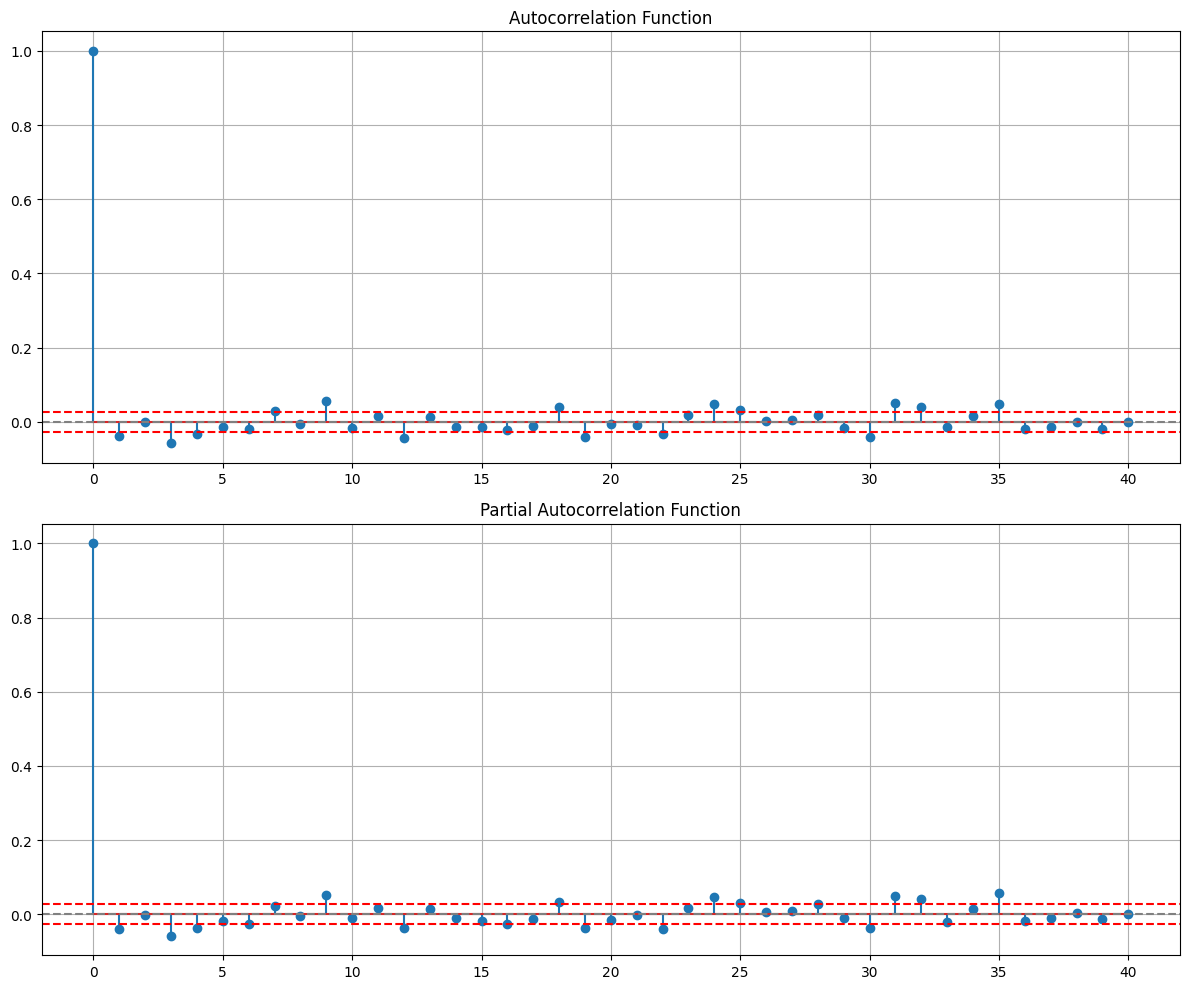

In [8]:
# Plot ACF and PACF to identify AR and MA terms
plt.figure(figsize=(12, 10))
plt.subplot(211)
acf_values = acf(diff_data, nlags=40)
plt.stem(range(len(acf_values)), acf_values)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_data)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(diff_data)), linestyle='--', color='red')
plt.title('Autocorrelation Function')
plt.grid(True)

plt.subplot(212)
pacf_values = pacf(diff_data, nlags=40)
plt.stem(range(len(pacf_values)), pacf_values)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_data)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(diff_data)), linestyle='--', color='red')
plt.title('Partial Autocorrelation Function')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# Split data into train and test ? 
train_size = 5130
train_data = stock_close[:train_size]
test_data = len(stock_close) - train_size
test_data = stock_close[train_size:]

print(f"\nTrain data: {len(train_data)} days")
print(f"Test data: {len(test_data)} days")


Train data: 5130 days
Test data: 72 days


In [10]:
from pmdarima import auto_arima

# Use auto_arima to find the best ARIMA model automatically
auto_model = auto_arima(train_data, seasonal=True, stepwise=True, suppress_warnings=True)
print(f"\nBest ARIMA order from auto_arima: {auto_model.order}")
print(f"Best seasonal order from auto_arima: {auto_model.seasonal_order}")
print(auto_model.summary())
train_data


Best ARIMA order from auto_arima: (5, 2, 0)
Best seasonal order from auto_arima: (0, 0, 0, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5130
Model:               SARIMAX(5, 2, 0)   Log Likelihood               -8728.510
Date:                Wed, 07 May 2025   AIC                          17469.021
Time:                        12:34:37   BIC                          17508.276
Sample:                             0   HQIC                         17482.761
                               - 5130                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8190      0.006   -134.895      0.000      -0.831      -0.807
ar.L2         -0.6665      0.008    

Ticker,GOOG
Date,
2004-08-19,2.487352
2004-08-20,2.684922
2004-08-23,2.711942
2004-08-24,2.599647
2004-08-25,2.627658
...,...
2024-12-30,192.470734
2024-12-31,190.223282
2025-01-02,190.413071



Forecasted values for the test period before pd.series:
5130    197.860910
5131    198.429036
5132    199.399673
5133    201.056226
5134    202.812408
           ...    
5197    290.706563
5198    292.103025
5199    293.499488
5200    294.895951
5201    296.292413
Length: 72, dtype: float64

Forecasted values with correct index:
Date
2025-01-07    197.860910
2025-01-08    198.429036
2025-01-10    199.399673
2025-01-13    201.056226
2025-01-14    202.812408
Name: Forecast, dtype: float64


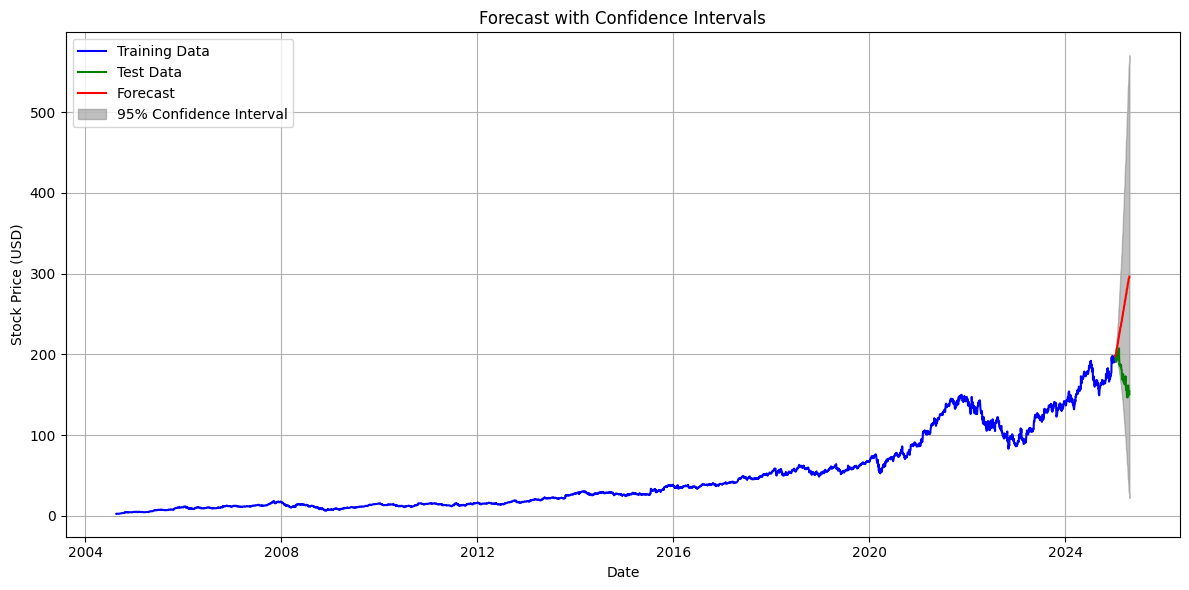

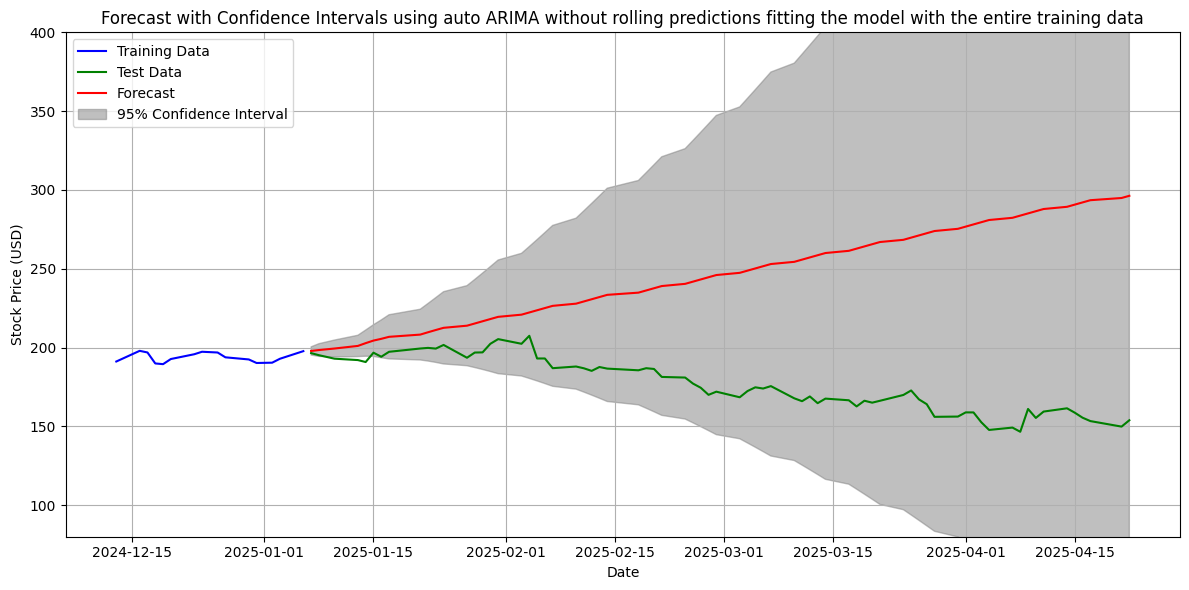

In [11]:
#without rolling predictions
# Fit the model on the entire training data
model = auto_arima(train_data, seasonal=True, stepwise=True, suppress_warnings=False)

# After generating your forecast
forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)
print(f"\nForecasted values for the test period before pd.series:\n{forecast}")

# Convert to numpy array first to discard the original indices
forecast_values = np.array(forecast)
forecast_df_1day = pd.Series(forecast_values, index=test_data.index, name='Forecast')
print(f"\nForecasted values with correct index:\n{forecast_df_1day.head()}")

# Similarly for confidence intervals
conf_int_array = np.array(conf_int)
conf_int_df = pd.DataFrame(conf_int_array, 
                          index=test_data.index, 
                          columns=['Lower Bound', 'Upper Bound'])

# Plot the forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data', color='blue')
plt.plot(test_data, label='Test Data', color='green')
plt.plot(forecast_df_1day, label='Forecast', color='red')
plt.fill_between(conf_int_df.index, 
                 conf_int_df['Lower Bound'], 
                 conf_int_df['Upper Bound'], 
                 color='gray', alpha=0.5, 
                 label='95% Confidence Interval')
plt.title('Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_data[-15:], label='Training Data', color='blue')
plt.plot(test_data, label='Test Data', color='green')
plt.plot(forecast_df_1day, label='Forecast', color='red')
plt.fill_between(conf_int_df.index, conf_int_df['Lower Bound'], conf_int_df['Upper Bound'], color='gray', alpha=0.5, label='95% Confidence Interval')
plt.title('Forecast with Confidence Intervals using auto ARIMA without rolling predictions fitting the model with the entire training data')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.ylim(80, 400)  # Set y-axis limits
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Forecasted values for the test period before pd.series:
10    196.706824
11    194.152096
12    194.152096
13    194.152096
14    194.152096
         ...    
77    194.152096
78    194.152096
79    194.152096
80    194.152096
81    194.152096
Length: 72, dtype: float64

Forecasted values with correct index:
Date
2025-01-07    196.706824
2025-01-08    194.152096
2025-01-10    194.152096
2025-01-13    194.152096
2025-01-14    194.152096
Name: Forecast, dtype: float64


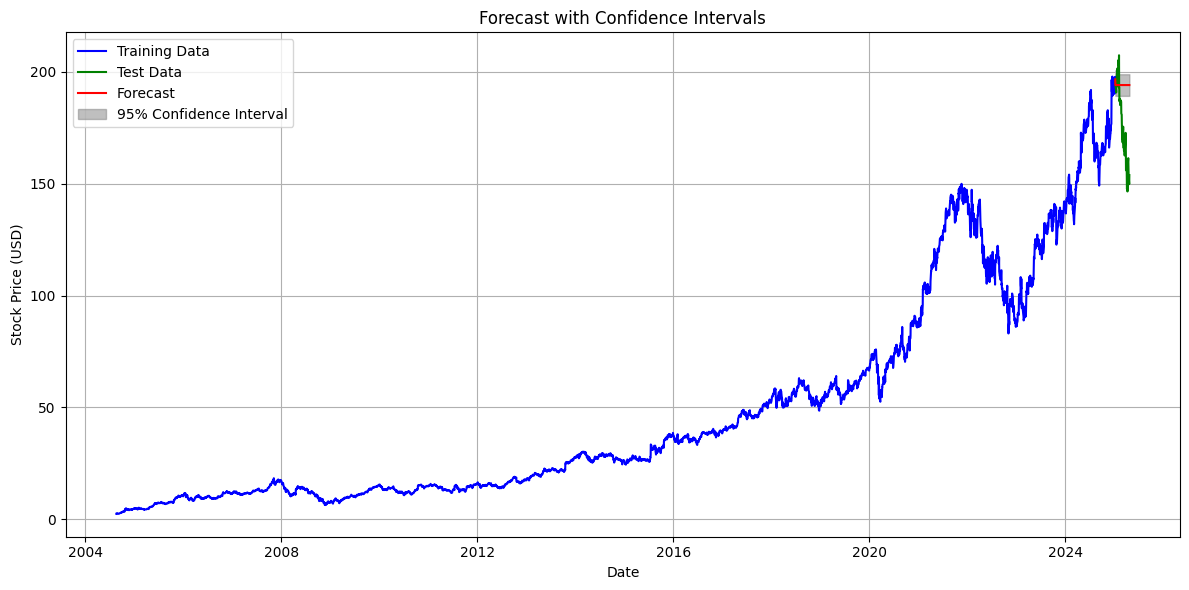

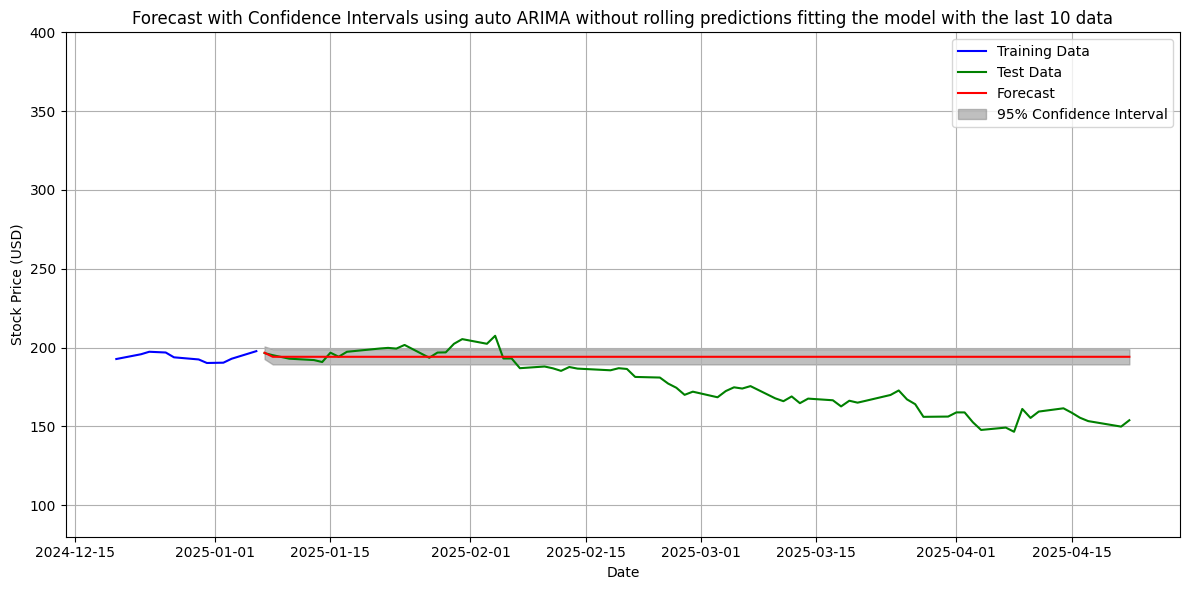

In [148]:
#without rolling predictions using the last 10 data, predicting the data in the test set
# Fit the model on the entire training data
model = auto_arima(train_data[-10:], seasonal=True, stepwise=True, suppress_warnings=False)

# After generating your forecast
forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)
print(f"\nForecasted values for the test period before pd.series:\n{forecast}")

# Convert to numpy array first to discard the original indices
forecast_values = np.array(forecast)
forecast_df_last10day = pd.Series(forecast_values, index=test_data.index, name='Forecast')
print(f"\nForecasted values with correct index:\n{forecast_df_last10day.head()}")

# Similarly for confidence intervals
conf_int_array = np.array(conf_int)
conf_int_df = pd.DataFrame(conf_int_array, 
                          index=test_data.index, 
                          columns=['Lower Bound', 'Upper Bound'])

# Plot the forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data', color='blue')
plt.plot(test_data, label='Test Data', color='green')
plt.plot(forecast_df_last10day, label='Forecast', color='red')
plt.fill_between(conf_int_df.index, 
                 conf_int_df['Lower Bound'], 
                 conf_int_df['Upper Bound'], 
                 color='gray', alpha=0.5, 
                 label='95% Confidence Interval')
plt.title('Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_data[-10:], label='Training Data', color='blue')
plt.plot(test_data, label='Test Data', color='green')
plt.plot(forecast_df_last10day, label='Forecast', color='red')
plt.fill_between(conf_int_df.index, conf_int_df['Lower Bound'], conf_int_df['Upper Bound'], color='gray', alpha=0.5, label='95% Confidence Interval')
plt.title('Forecast with Confidence Intervals using auto ARIMA without rolling predictions fitting the model with the last 10 data')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.ylim(80, 400)  # Set y-axis limits
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [97]:
test_data

Ticker,GOOG
Date,
2025-01-07,196.486160
2025-01-08,195.167648
2025-01-10,192.950180
2025-01-13,192.071167
2025-01-14,190.832596
...,...
2025-04-15,158.679993
2025-04-16,155.500000
2025-04-17,153.360001


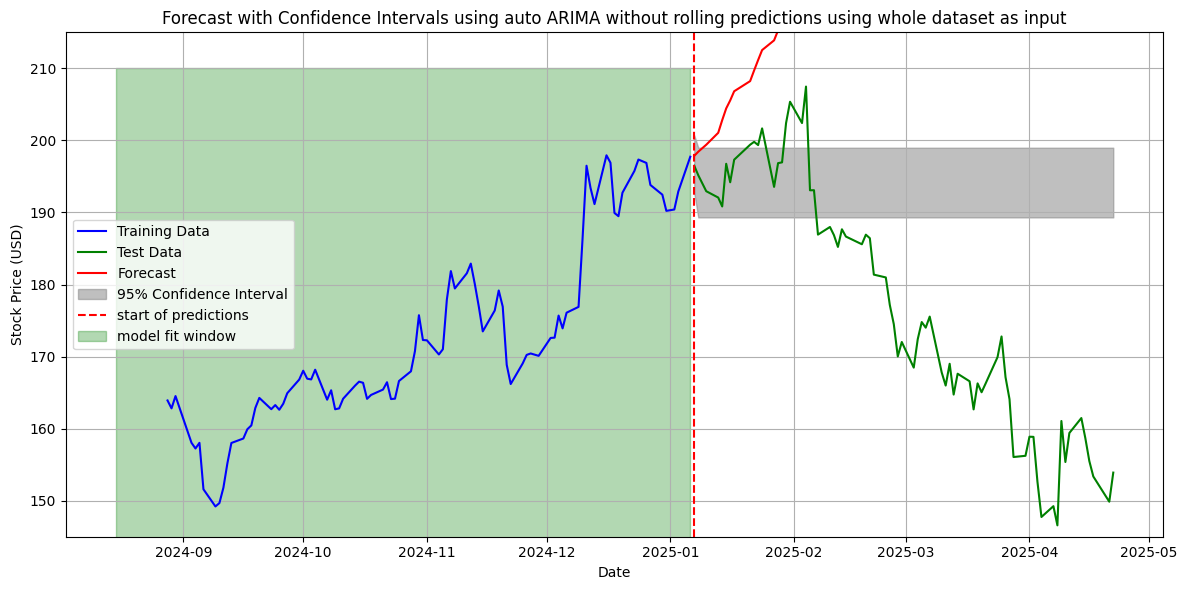

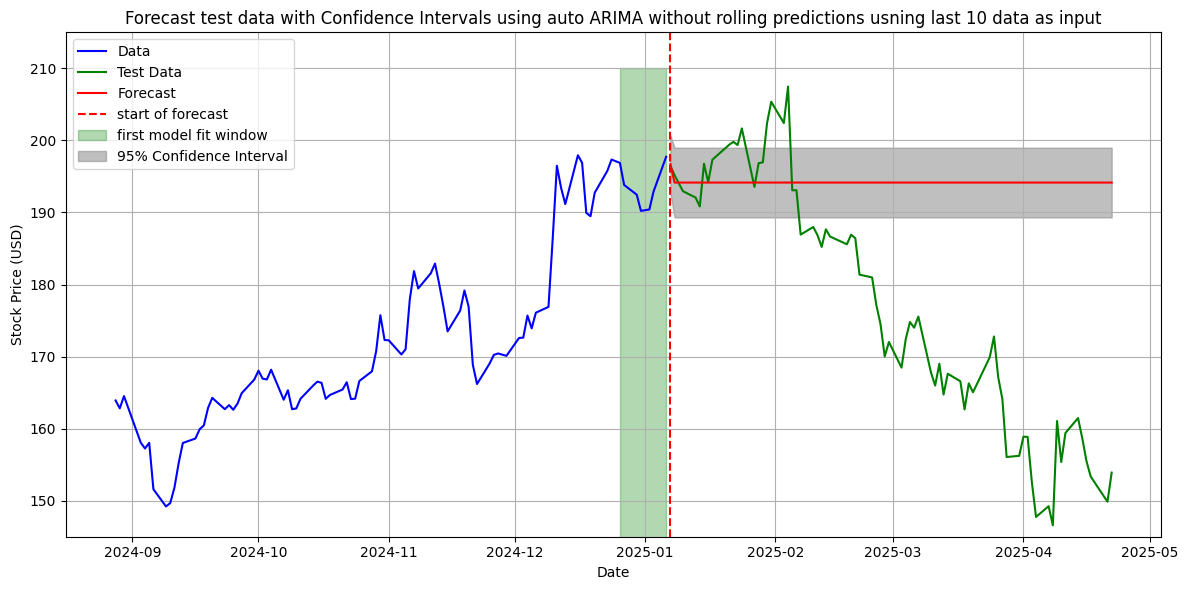

In [149]:
plt.figure(figsize=(12, 6))
plt.plot(train_data[-90:], label='Training Data', color='blue')
plt.plot(test_data, label='Test Data', color='green')
plt.plot(forecast_df_1day, label='Forecast', color='red')
plt.fill_between(conf_int_df.index, conf_int_df['Lower Bound'], conf_int_df['Upper Bound'], color='gray', alpha=0.5, label='95% Confidence Interval')
plt.axvline(x=pd.Timestamp('2025-01-07'), color='red', linestyle='--', label='start of predictions')
plt.fill_betweenx(y=[130, 210], x1=pd.Timestamp('2024-08-15'), x2=pd.Timestamp('2025-01-06'), color='green', alpha=0.3, label='model fit window')
plt.title('Forecast with Confidence Intervals using auto ARIMA without rolling predictions using whole dataset as input')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.ylim(145, 215)  # Set y-axis limits
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_data[-90:], label='Data', color='blue')
plt.plot(test_data, label='Test Data', color='green')
plt.plot(forecast_df_last10day, label='Forecast', color='red')
#add vertical line for test split date with enlarged x-axis
plt.axvline(x=pd.Timestamp('2025-01-07'), color='red', linestyle='--', label='start of forecast')
#fill between the start and end dates of the first model fit window
plt.fill_betweenx(y=[130, 210], x1=pd.Timestamp('2024-12-26'), x2=pd.Timestamp('2025-01-06'), color='green', alpha=0.3, label='first model fit window')
plt.fill_between(conf_int_df.index, conf_int_df['Lower Bound'], conf_int_df['Upper Bound'], color='gray', alpha=0.5, label='95% Confidence Interval')
plt.title('Forecast test data with Confidence Intervals using auto ARIMA without rolling predictions usning last 10 data as input')

#fill between the start and end dates of the first model fit window
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.ylim(145, 215)  # Set y-axis limits
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [150]:
train_data[-10:]

Ticker,GOOG
Date,
2024-12-20,192.740417
2024-12-23,195.766968
2024-12-24,197.345184
2024-12-26,196.875717
2024-12-27,193.819183
2024-12-30,192.470734
2024-12-31,190.223282
2025-01-02,190.413071
2025-01-03,192.910233


In [151]:
# skipping the first "start_rolling" data points in the test set for rolling predictions with auto_arima and using the last data points in the training set rolling predictions
start_rolling = 35
rolling_predictions_with_10_day_skip = []
rolling_index = test_data.index[start_rolling:]  # Use the correct date index roll starting from the 10th test point

for i in range(start_rolling, len(test_data)):
    # Fit the model on the last 10 training data up to the current test point
    model = auto_arima(pd.concat([train_data, test_data.iloc[:i]]), seasonal=True, stepwise=True, suppress_warnings=False) #model fit from the start of the training data to the current test point
    forecast, conf_int = model.predict(n_periods=1, return_conf_int=True)
    rolling_predictions_with_10_day_skip.append(forecast.iloc[0])

rolling_predictions_with_10_day_skip_df = pd.Series(rolling_predictions_with_10_day_skip, index=rolling_index, name='Rolling Forecast')
print(f"\nRolling predictions:\n{rolling_predictions_with_10_day_skip_df.head()}")

#adding proper index to the rolling predictions
rolling_predictions_with_10_day_skip_df.index = test_data.index[start_rolling:]
print(f"\nRolling predictions with correct index:\n{rolling_predictions_with_10_day_skip_df.head()}")

KeyboardInterrupt: 

In [ ]:
train_data

Ticker,GOOG
Date,
2004-08-19,2.487352
2004-08-20,2.684922
2004-08-23,2.711942
2004-08-24,2.599647
2004-08-25,2.627658
...,...
2024-12-30,192.470734
2024-12-31,190.223282
2025-01-02,190.413071


In [ ]:

rolling_predictions_with_10_day_skip_df

Date
2025-01-23    200.911738
2025-01-24    200.819458
2025-01-27    202.545240
2025-01-28    193.357031
2025-01-29    196.821255
                 ...    
2025-04-15    161.095913
2025-04-16    158.654873
2025-04-17    155.624113
2025-04-21    153.552270
2025-04-22    150.156620
Name: Rolling Forecast, Length: 62, dtype: float64

In [ ]:
stock_data

Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2004-08-19,2.487352,2.579567,2.378775,2.478923,897427216
2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2004-08-23,2.711942,2.813082,2.703266,2.745408,366857939
2004-08-24,2.599647,2.766478,2.567420,2.757554,306396159
2004-08-25,2.627658,2.677237,2.575105,2.601877,184645512
...,...,...,...,...,...
2025-04-15,158.679993,162.050003,157.645004,161.570007,15690800
2025-04-16,155.500000,158.179993,153.910004,155.470001,16921500


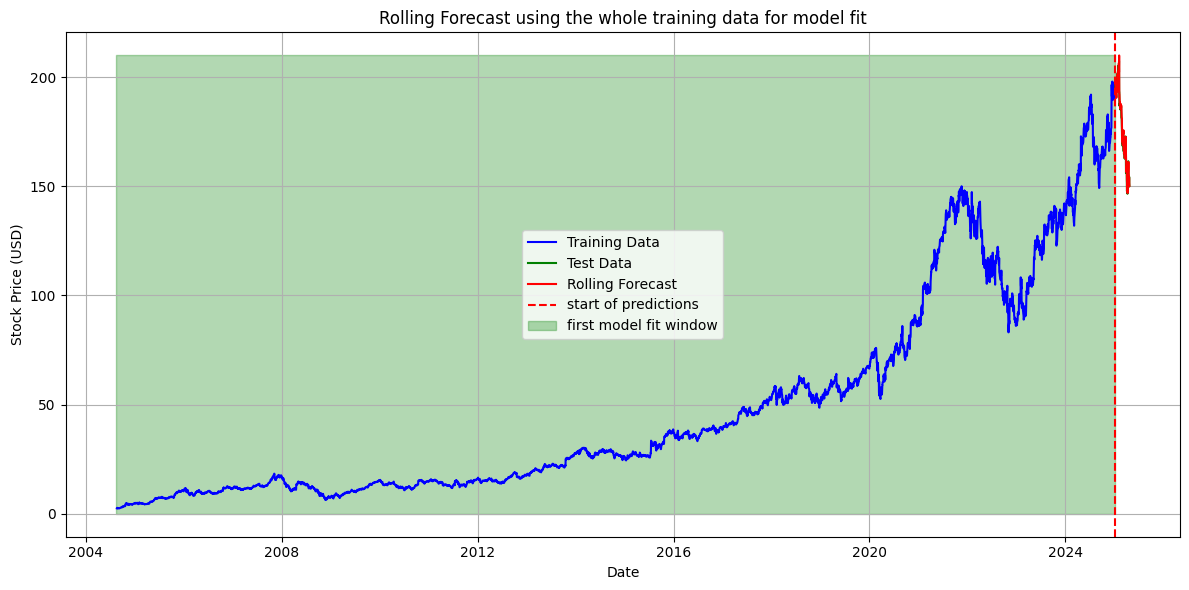

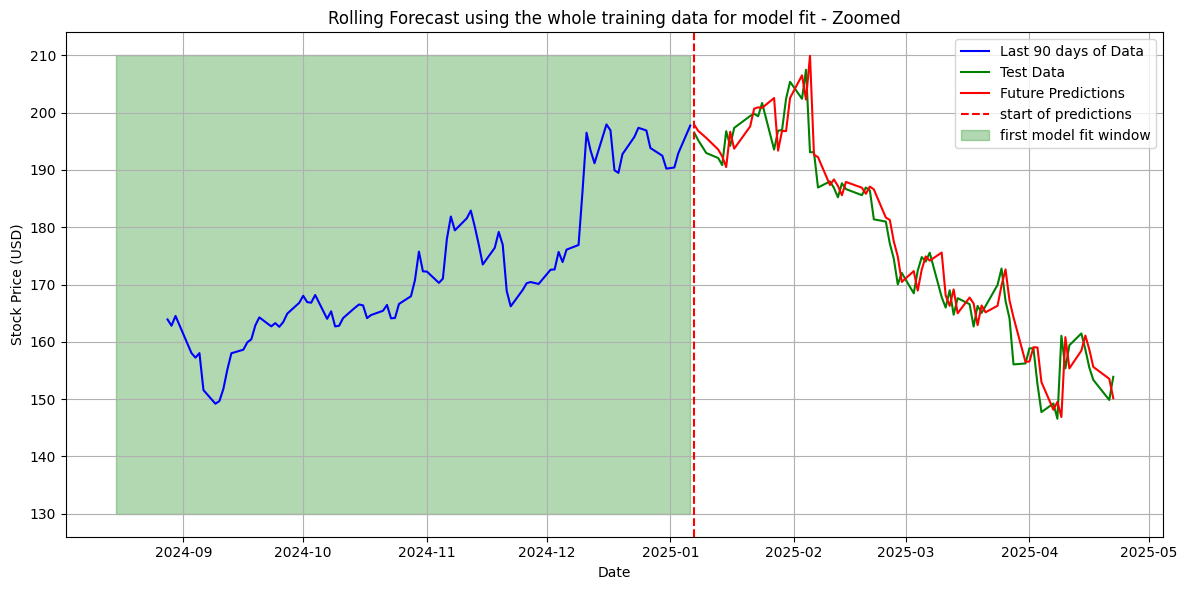

In [ ]:
#plot rolling predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data', color='blue')
plt.plot(test_data, label='Test Data', color='green')
plt.plot(rolling_predictions_with_10_day_skip_df, label='Rolling Forecast', color='red')
plt.axvline(x=pd.Timestamp('2025-01-07'), color='red', linestyle='--', label='start of predictions')
#fill between the start and end dates of the first model fit window
plt.fill_betweenx(y=[0, 210], x1=pd.Timestamp('2004-08-15'), x2=pd.Timestamp('2025-01-06'), color='green', alpha=0.3, label='first model fit window')
plt.title('Rolling Forecast using the whole training data for model fit')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#plotting the last 90 days + predictions with test data
plt.figure(figsize=(12, 6))
plt.plot(train_data[-90:], label='Last 90 days of Data', color='blue')
plt.plot(test_data, label='Test Data', color='green')
plt.plot(rolling_predictions_with_10_day_skip_df, label='Future Predictions', color='red')
plt.axvline(x=pd.Timestamp('2025-01-07'), color='red', linestyle='--', label='start of predictions')
#fill between the start and end dates of the first model fit window
plt.fill_betweenx(y=[130, 210], x1=pd.Timestamp('2024-08-15'), x2=pd.Timestamp('2025-01-06'), color='green', alpha=0.3, label='first model fit window')
plt.title('Rolling Forecast using the whole training data for model fit - Zoomed')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# skipping the first 0 data points in the test set for rolling predictions with auto_arima and using the last 10 data points in the training set rolling predictions
start_rolling = 0 
rolling_predictions_with_10_day_skip_using_last_10_train_data_only = []
rolling_index = test_data.index[start_rolling:]  # Use the correct date index roll starting from the 55th test point

for i in range(start_rolling, len(test_data)):
    # Fit the model on the last 10 training data up to the current test point
    model = auto_arima(pd.concat([train_data[-10:], test_data.iloc[:i]]), seasonal=True, stepwise=True, suppress_warnings=False) #model fit from the start of the training data to the current test point
    forecast, conf_int = model.predict(n_periods=1, return_conf_int=True)
    rolling_predictions_with_10_day_skip_using_last_10_train_data_only.append(forecast.iloc[0])

rolling_predictions_with_10_day_skip_using_last_10_train_data_only_df = pd.Series(rolling_predictions_with_10_day_skip_using_last_10_train_data_only, index=rolling_index, name='Rolling Forecast')
print(f"\nRolling predictions:\n{rolling_predictions_with_10_day_skip_using_last_10_train_data_only_df.head()}")

#adding proper index to the rolling predictions
rolling_predictions_with_10_day_skip_using_last_10_train_data_only_df.index = test_data.index[start_rolling:]
print(f"\nRolling predictions with correct index:\n{rolling_predictions_with_10_day_skip_using_last_10_train_data_only_df.head()}")


Rolling predictions:
Date
2025-01-07    196.706824
2025-01-08    193.999880
2025-01-10    194.910547
2025-01-13    193.913994
2025-01-14    192.107326
Name: Rolling Forecast, dtype: float64

Rolling predictions with correct index:
Date
2025-01-07    196.706824
2025-01-08    193.999880
2025-01-10    194.910547
2025-01-13    193.913994
2025-01-14    192.107326
Name: Rolling Forecast, dtype: float64


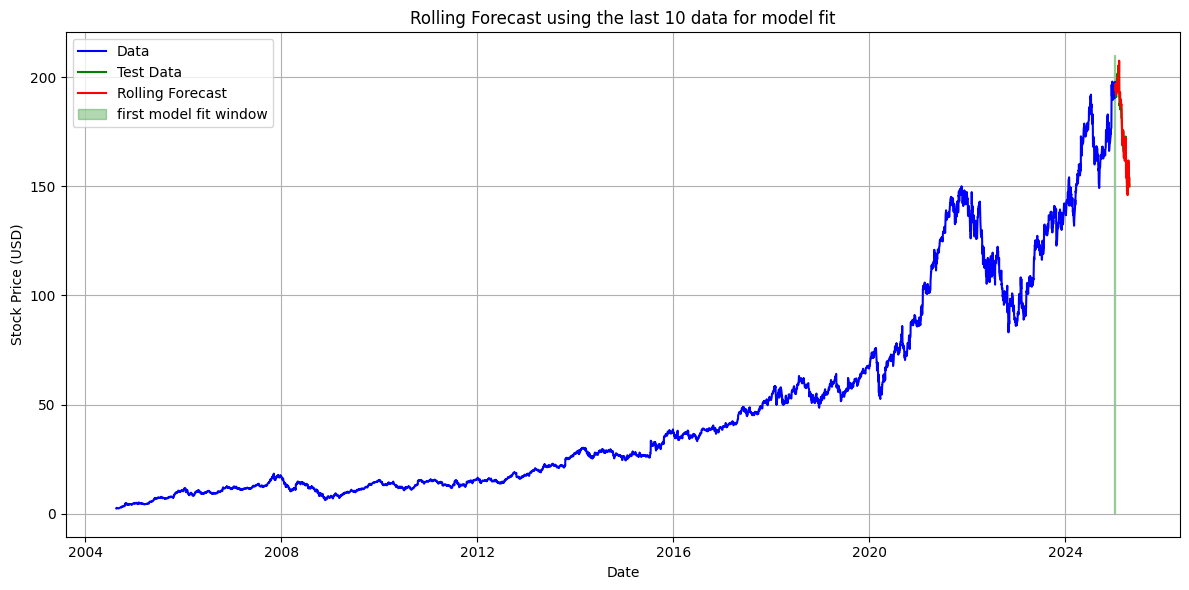

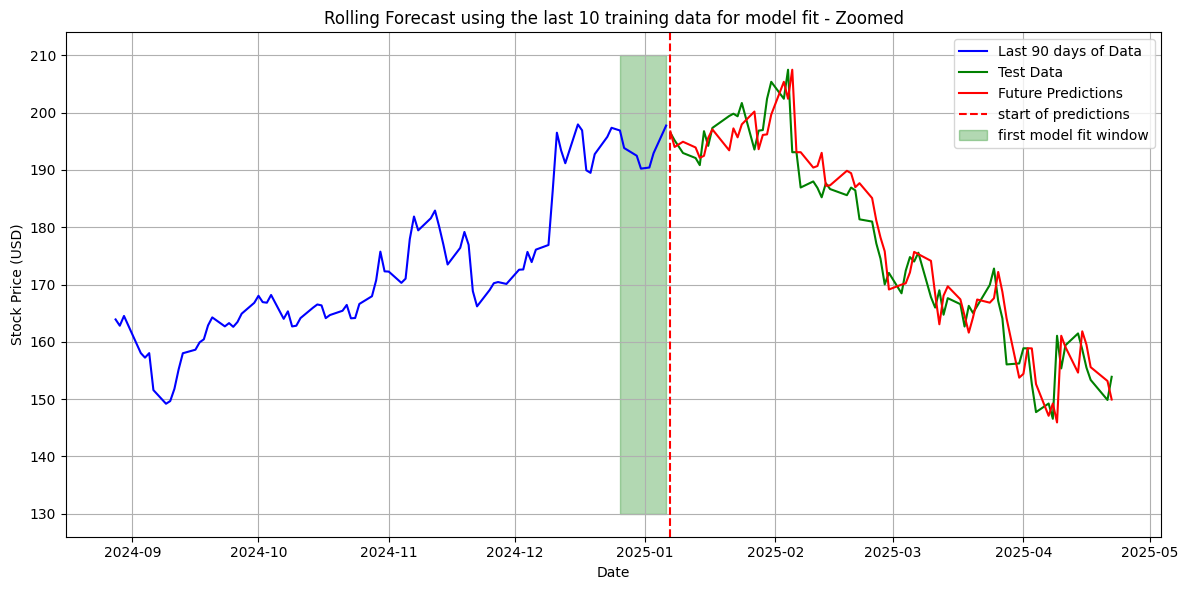

In [152]:
#plot rolling predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Data', color='blue')
plt.plot(test_data, label='Test Data', color='green')
plt.plot(rolling_predictions_with_10_day_skip_using_last_10_train_data_only_df, label='Rolling Forecast', color='red')
plt.fill_betweenx(y=[0, 210], x1=pd.Timestamp('2024-12-26'), x2=pd.Timestamp('2025-01-06'), color='green', alpha=0.3, label='first model fit window')
plt.title('Rolling Forecast using the last 10 data for model fit')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#plotting the last 90 days + predictions with test data
plt.figure(figsize=(12, 6))
plt.plot(train_data[-90:], label='Last 90 days of Data', color='blue')
plt.plot(test_data, label='Test Data', color='green')
plt.plot(rolling_predictions_with_10_day_skip_using_last_10_train_data_only_df, label='Future Predictions', color='red')
plt.axvline(x=pd.Timestamp('2025-01-07'), color='red', linestyle='--', label='start of predictions')
#fill between the start and end dates of the first model fit window
plt.fill_betweenx(y=[130, 210], x1=pd.Timestamp('2024-12-26'), x2=pd.Timestamp('2025-01-06'), color='green', alpha=0.3, label='first model fit window')
plt.title('Rolling Forecast using the last 10 training data for model fit - Zoomed')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [72]:
rolling_predictions_with_10_day_skip_using_last_10_train_data_only_df

Date
2025-01-23    195.680895
2025-01-24    197.947638
2025-01-27    200.177801
2025-01-28    193.608007
2025-01-29    196.099227
                 ...    
2025-04-15    161.836906
2025-04-16    159.505902
2025-04-17    155.582011
2025-04-21    153.172334
2025-04-22    149.942080
Name: Rolling Forecast, Length: 62, dtype: float64

In [71]:
stock_data

Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2004-08-19,2.487352,2.579567,2.378775,2.478922,897427216
2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2004-08-23,2.711942,2.813082,2.703266,2.745408,366857939
2004-08-24,2.599647,2.766478,2.567421,2.757554,306396159
2004-08-25,2.627658,2.677238,2.575105,2.601877,184645512
...,...,...,...,...,...
2025-04-15,158.679993,162.050003,157.645004,161.570007,15690800
2025-04-16,155.500000,158.179993,153.910004,155.470001,16921500


In [153]:
# Check columns before exporting
print(stock_data.columns.tolist())

# Concatenate predictions with original stock data, but do not overwrite
stock_data_with_predictions = pd.concat([stock_data, rolling_predictions_with_10_day_skip_using_last_10_train_data_only_df], axis=1)

with pd.ExcelWriter('GOOG_stock_data_with_predictions_{rolling_predictions_with_10_day_skip_using_last_10_train_data_only_df}.xlsx') as writer:
    # Save the full data with predictions
    stock_data_with_predictions.to_excel(writer, index=True, sheet_name='GOOG Stock Data')
    
    # Save only the 'Close' column if it exists
    if 'Close' in stock_data.columns:
        stock_data[['Close']].to_excel(writer, index=True, sheet_name='GOOG Stock Data Close Prices')
    else:
        print("Column 'Close' not found in stock_data. Available columns:", stock_data.columns.tolist())
    
    # Save predictions to a separate sheet
    rolling_predictions_with_10_day_skip_using_last_10_train_data_only_df.to_excel(writer, index=True, sheet_name='Predictions')

[('Close', 'GOOG'), ('High', 'GOOG'), ('Low', 'GOOG'), ('Open', 'GOOG'), ('Volume', 'GOOG')]


Using last 10 dataset only for rolling window or full dataset makes almost 0 difference but shortens the predic time (7 sec compares to 150sec)

In [154]:
# Comparsion of accuracy between whole dataset vs last 10 data points for rolling predictions
mse_whole_dataset = mean_squared_error(test_data, rolling_predictions_with_10_day_skip_df)
mse_last_10_data = mean_squared_error(test_data, rolling_predictions_with_10_day_skip_using_last_10_train_data_only_df)
print(f"\nMean Squared Error (MSE) using whole dataset for rolling predictions: {mse_whole_dataset}")
print(f"Mean Squared Error (MSE) using last 10 data points for rolling predictions: {mse_last_10_data}")



Mean Squared Error (MSE) using whole dataset for rolling predictions: 18.72405374903192
Mean Squared Error (MSE) using last 10 data points for rolling predictions: 20.768187959935535


###---------------------------------------------------------------------------END OF PROJECT------------------------------------------------------------------

#Window size adjustable

In [11]:
import os
import pickle
from datetime import datetime

# Create cache directory if it doesn't exist
cache_dir = 'arima_cache'
os.makedirs(cache_dir, exist_ok=True)

# Define rolling window size
roll_window = 1  # Number of days to roll over - can be adjusted to different values

# Master cache file path
master_cache_file = os.path.join(cache_dir, f'rolling_predictions_{roll_window}day.pkl')

# Initialize or load predictions
if os.path.exists(master_cache_file):
    try:
        with open(master_cache_file, 'rb') as f:
            cache_data = pickle.load(f)
            rolling_predictions = cache_data['predictions']
            last_predicted_idx = cache_data['last_idx']
            print(f"Loaded {len(rolling_predictions)} cached predictions up to {test_data.index[last_predicted_idx]}")
            
            # Update history with data up to last prediction
            history = train_data.copy()
            if isinstance(history, pd.DataFrame):
                history = history.iloc[:, 0]
            
            # Add test data to history up to the last predicted index
            for i in range(0, min(last_predicted_idx + 1, len(test_data))):
                date = test_data.index[i]
                value = test_data.iloc[i]
                new_value = pd.Series([value], index=[date], name=history.name)
                history = pd.concat([history, new_value])
                history = history.astype(float)
                if isinstance(history, pd.DataFrame):
                    history = history.iloc[:, 0]
            
            # Start from next prediction point
            start_idx = last_predicted_idx + 1
    except Exception as e:
        print(f"Error loading cache: {e}, starting fresh")
        rolling_predictions = []
        history = train_data.copy()
        if isinstance(history, pd.DataFrame):
            history = history.iloc[:, 0]
        start_idx = 0
else:
    rolling_predictions = []
    history = train_data.copy()
    if isinstance(history, pd.DataFrame):
        history = history.iloc[:, 0]
    start_idx = 0

# Continue predictions from where we left off
for t in range(start_idx, len(test_data), roll_window):
    # Determine number of steps to predict (handle edge case at end of data)
    steps_ahead = min(roll_window, len(test_data) - t)
    
    # Create a batch ID for caching
    batch_start_date = test_data.index[t].strftime('%Y-%m-%d')
    batch_end_idx = min(t + steps_ahead - 1, len(test_data) - 1)
    batch_end_date = test_data.index[batch_end_idx].strftime('%Y-%m-%d')
    batch_id = f"{batch_start_date}_to_{batch_end_date}_w{roll_window}"
    pred_cache_file = os.path.join(cache_dir, f'prediction_batch_{batch_id}.pkl')
    
    if os.path.exists(pred_cache_file):
        # Load batch from cache
        with open(pred_cache_file, 'rb') as f:
            cached_result = pickle.load(f)
            pred_values = cached_result['predictions']
            conf_ints = cached_result['confidence_intervals']
        print(f"Loaded {len(pred_values)} predictions for {batch_id} from cache")
    else:
        # Compute new predictions for the window
        model = auto_arima(history, seasonal=True, stepwise=True, suppress_warnings=True)
        pred, conf_int = model.predict(n_periods=steps_ahead, return_conf_int=True)
        
        # Ensure pred is a Series
        if not isinstance(pred, pd.Series):
            pred = pd.Series(pred)
        
        pred_values = pred.values
        
        # Save batch prediction
        with open(pred_cache_file, 'wb') as f:
            pickle.dump({
                'predictions': pred_values,
                'confidence_intervals': conf_int,
                'model_params': model.get_params(),
                'start_date': test_data.index[t],
                'end_date': test_data.index[batch_end_idx],
                'window_size': roll_window
            }, f)
        print(f"Computed and cached {len(pred_values)} predictions for {batch_id}")
    
    # Add predictions to the rolling predictions list
    for i, pred_value in enumerate(pred_values):
        if t + i < len(test_data):  # Safety check
            rolling_predictions.append(pred_value)
            current_date = test_data.index[t + i]
            print(f"Predicted value for {current_date}: {pred_value}")
    
    # Update history with actual values after predictions are made
    for i in range(steps_ahead):
        if t + i < len(test_data):  # Safety check
            current_date = test_data.index[t + i]
            value = test_data.iloc[t + i]
            new_value = pd.Series([value], index=[current_date], name=history.name)
            history = pd.concat([history, new_value])
            history = history.astype(float)
            if isinstance(history, pd.DataFrame):
                history = history.iloc[:, 0]
    
    # Update master cache file periodically
    if t % (roll_window * 10) == 0 or t >= len(test_data) - roll_window:
        with open(master_cache_file, 'wb') as f:
            pickle.dump({
                'predictions': rolling_predictions,
                'dates': test_data.index[:len(rolling_predictions)].tolist(),
                'last_idx': t + steps_ahead - 1,
                'window_size': roll_window,
                'last_updated': datetime.now()
            }, f)
        print(f"Updated master cache with {len(rolling_predictions)} predictions")


Loaded 30 cached predictions up to 2025-04-22 00:00:00


In [12]:
# Calculate RMSE for rolling predictions
rolling_rmse = np.sqrt(mean_squared_error(test_data[:len(rolling_predictions)], rolling_predictions))
test_data_mean_value = test_data[:len(rolling_predictions)].mean()
print(f"\nRolling RMSE: {rolling_rmse:.2f}")
print(f"Rolling RMSE percentage of average price: {rolling_rmse/float(test_data_mean_value)*100:.2f}%")



Rolling RMSE: 4.43
Rolling RMSE percentage of average price: 2.76%


In [13]:
# Save final predictions for easy access
with open(f'final_rolling_predictions_{roll_window}day.pkl', 'wb') as f:
    pickle.dump({
        'predictions': rolling_predictions,
        'dates': test_data.index[:len(rolling_predictions)].tolist(),
        'rmse': rolling_rmse,
        'rmse_percentage': rolling_rmse/test_data_mean_value*100
    }, f)
print(f"Saved final predictions to final_rolling_predictions_{roll_window}day.pkl")

Saved final predictions to final_rolling_predictions_1day.pkl


!!!!!!!!Megtévesztő lehet az ábra. 1. 90 nap training nem ablak illetve a predikciók mindig csak a következő napra szólnak az is megtévesztő lehet!!!!!!!!!!

In [9]:
#plotting the last 90 days + predictions with test data
plt.figure(figsize=(12, 6))
plt.plot(train_data[-90:], label='Last 90 Days of Training Data + rolling next day prediction with refit the model', color='blue')
plt.plot(test_data, label='Ground truth', color='green')
plt.plot(test_data.index, rolling_predictions, label=f'Rolling Predictions {roll_window}days', color='red')
plt.title('Last 90 Days of Training Data and Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'train_data' is not defined

<Figure size 1200x600 with 0 Axes>

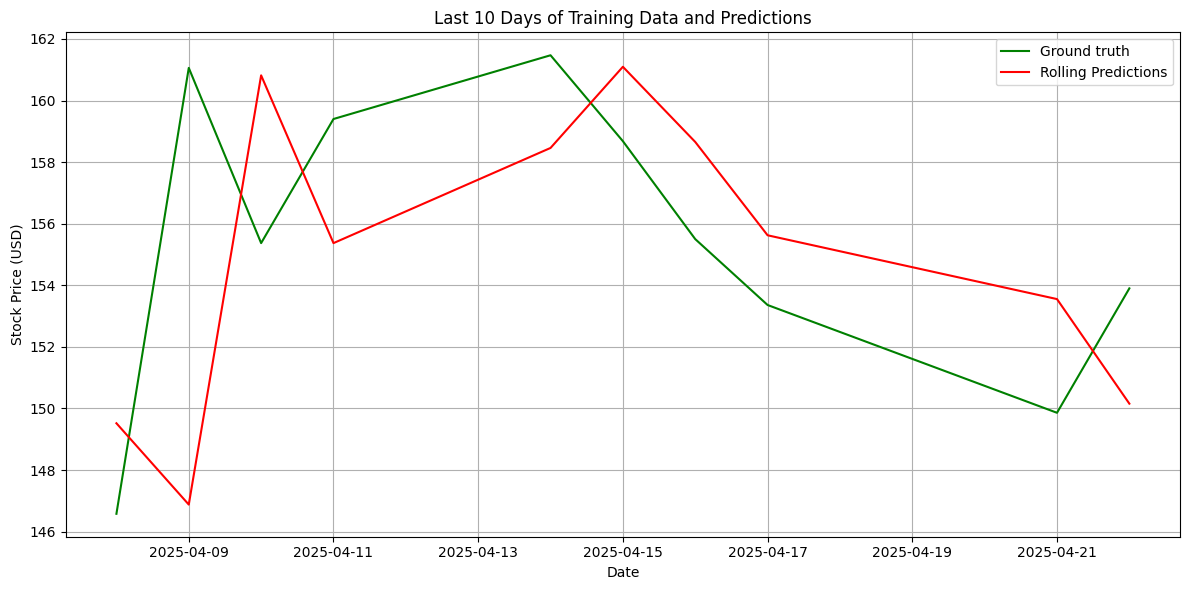

In [15]:
#plotting the last 10 days of predictions with test data
plt.figure(figsize=(12, 6))
#plt.plot(train_data[-10:], label='Last 10 Days of Training Data', color='blue')
plt.plot(test_data[-10:], label='Ground truth', color='green')
plt.plot(test_data.index[-10:], rolling_predictions[-10:], label='Rolling Predictions', color='red')
plt.title('Last 10 Days of Training Data and Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [16]:
from tqdm.notebook import tqdm

def plot_future_predictions(stock_close, roll_window):
    # Add future dates for predictions
    future_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=roll_window, freq='B')
    future_predictions = []
    
    # Initialize history
    history = train_data.copy()
    if isinstance(history, pd.DataFrame):
        history = history.iloc[:, 0]
    
    # Add progress bar to track execution
    for t in tqdm(range(len(test_data)), desc="Processing predictions", leave=True):
        # Fit model
        model = auto_arima(history, seasonal=True, stepwise=True, suppress_warnings=True)
        pred = model.predict(n_periods=1)
        # pred is a numpy array of length 1; extract the scalar
        future_predictions.append(pred.iloc[0])
        # Create new_value as a Series with the same name as history
        new_value = pd.Series([test_data.iloc[t]], index=[test_data.index[t]], name=history.name)
        # Concatenate and ensure result is a Series
        history = pd.concat([history, new_value])
        history = history.astype(float)  # Ensure dtype is float
        # If somehow history becomes a DataFrame, convert back to Series
        if isinstance(history, pd.DataFrame):
            history = history.iloc[:, 0]

    return future_predictions, future_dates[:len(future_predictions)]

future_predictions, future_dates = plot_future_predictions(stock_close, roll_window)

Processing predictions:   0%|          | 0/30 [00:00<?, ?it/s]

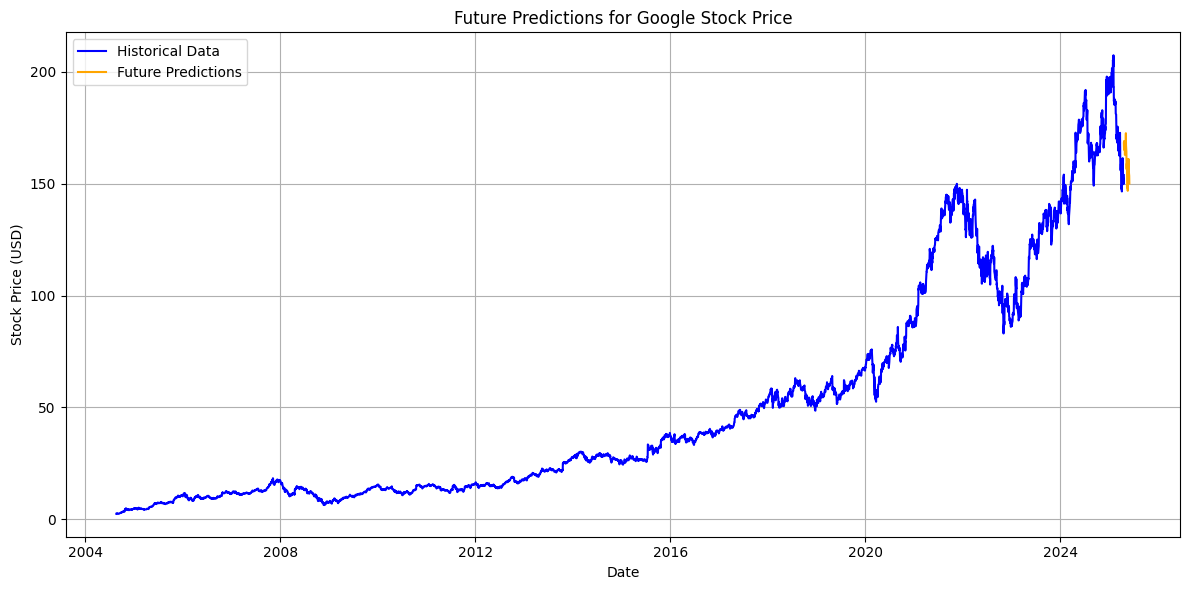

In [21]:
    # Plot future predictions
    plt.figure(figsize=(12, 6))
    plt.plot(stock_close, label='Historical Data', color='blue')
    # Create a Series with proper dates for future_predictions
    future_pred_series = pd.Series(future_predictions, index=future_dates[:len(test_data)])
    plt.plot(future_pred_series, label='Future Predictions', color='orange')
    plt.title('Future Predictions for Google Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Stock Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
savemodel = True
if savemodel:
    import pickle
    with open('arima_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    print("Model saved to arima_model.pkl")

savepredictions = True
if savepredictions:
    with open('predictions.pkl', 'wb') as f:
        pickle.dump(future_predictions, f)
    print("Predictions saved to predictions.pkl")

print("predictions", future_predictions)


Model saved to arima_model.pkl
Predictions saved to predictions.pkl
predictions [165.15393939879058, 175.26980426023914, 168.2397393977225, 166.12341042561462, 168.98292073405142, 164.9183913856616, 167.63792998697332, 166.64102658287524, 162.9096275834123, 166.29900965466894, 165.13121852697387, 166.26285892139288, 169.77858390243335, 172.5621488904536, 167.24517120041423, 164.3091036694147, 156.58194304130606, 156.62262359995037, 159.07293818092586, 159.01475783423837, 153.02390138903587, 148.23007937290194, 149.54942962778898, 146.91591915396054, 160.71872367684824, 155.4901631304792, 158.3462718310691, 161.14438819147432, 158.41574326798423, 155.28572989720521, 153.8124238097083, 150.12723010806462]


Maybe not neccessary anymore:

In [19]:
print(len(future_predictions), len(test_data))
future_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')  
print(len(future_predictions), len(future_dates))

30 30
30 30


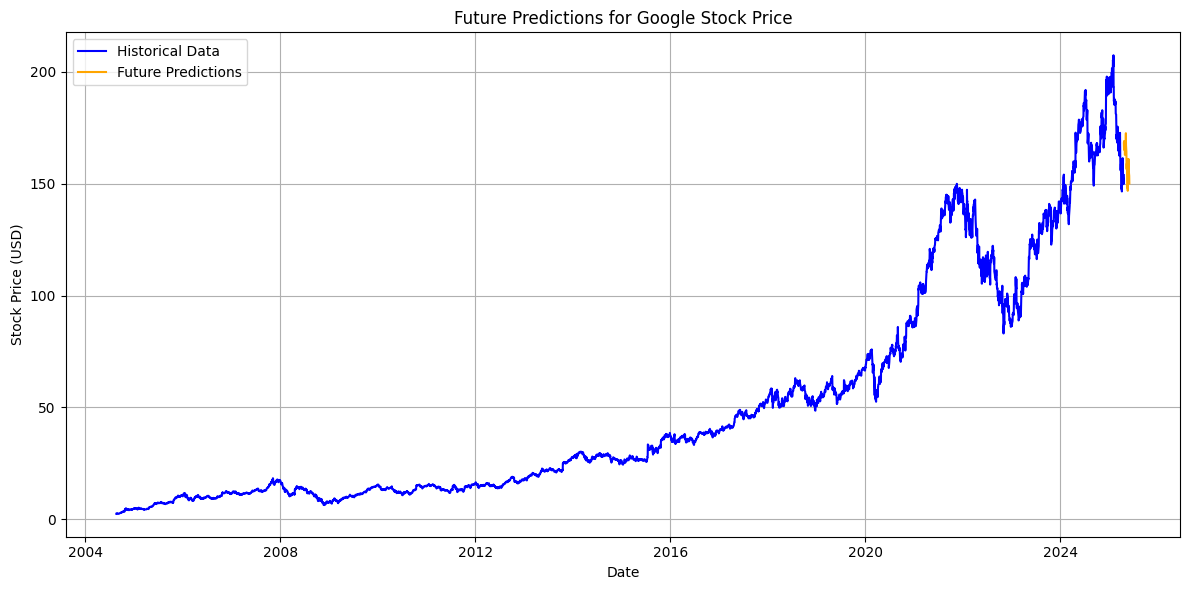

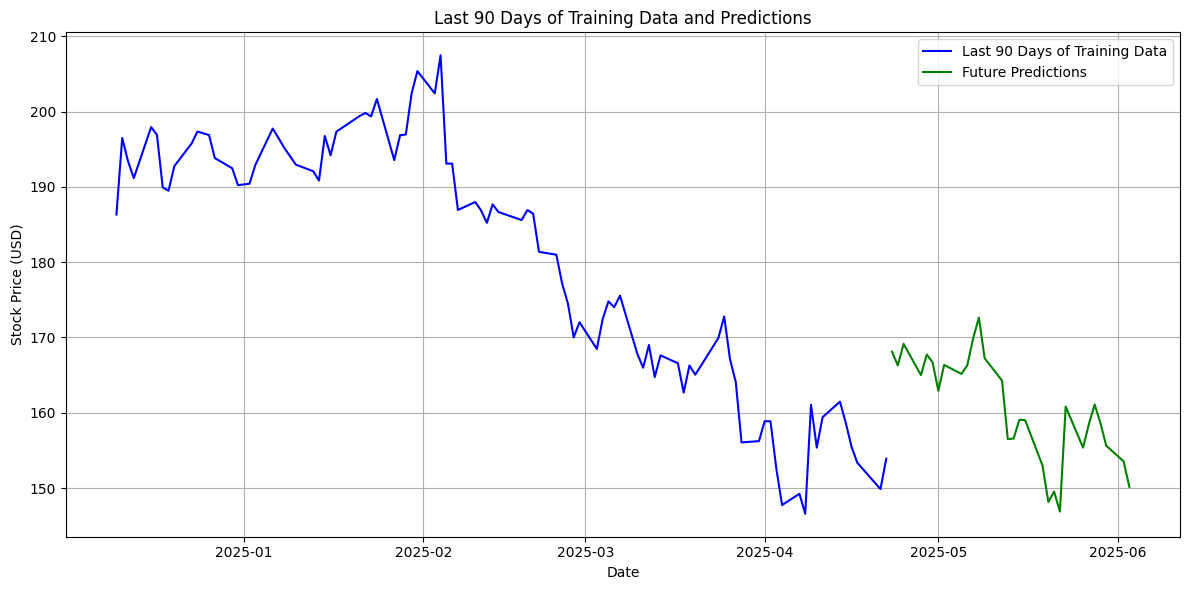

In [20]:
# shift future predictions to align with future dates
future_predictions_series = pd.Series(future_predictions, index=future_dates)
plt.figure(figsize=(12, 6))
plt.plot(stock_close, label='Historical Data', color='blue')
plt.plot(future_predictions_series, label='Future Predictions', color='orange')
plt.title('Future Predictions for Google Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#plotting the last 90 days + predictions with test data
plt.figure(figsize=(12, 6))
plt.plot(stock_close[-90:], label='Last 90 Days of Training Data', color='blue')
plt.plot(future_predictions_series, label='Future Predictions', color='green')
plt.title('Last 90 Days of Training Data and Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# hyperparameters
#Train data only previous 120 days of data, not the entire dataset
train_data_size = 120  # Number of days to use for training
train_data = stock_close[-train_data_size:]  # Last 120 days of data
train_test_split = int(len(train_data) * 0.8)  # 80% for training, 20% for testing
test_data = stock_close[-(len(stock_close) - train_data_size):]  # Remaining data for testing



Csak 1 nap előrejelzés.